# **LearningManager**: Create a Federated Learning Pipeline using MedFL
<img src='../Images/MEDfl_Diagramm.png' />

The `Learning Manager`, serving as the second subpackage of *Medfl*, extends the work initiated by the `NetManager`. It operates by taking the federated dataset as its input and, through its processes, generates a **Trained model**. Additionally, it **stores relevant Results** within the database.

<b>The Federated module</b>  of <b>MEDfl</b>, which is based on the <a href="https://flower.dev/">Flower</a> framework, is well designed for doing this task, it's mainly follows the flower paradigm, but with many customization, to deal with the SQL database, and to be homogeneous with the <b>NetManager</b>


<img src='../Images/LearningManager.png' width="50%" />


In [1]:
import sys
sys.path.append('../..')

import os
os.environ['PYTHONPATH'] = '../..'

Imports

In [2]:
# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

# flower imports 
import flwr as fl

# Medfl imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *

from Medfl.NetManager.flsetup import FLsetup
from Medfl.LearningManager.flpipeline import *

from Medfl.LearningManager.plot import AccuracyLossPlotter




2024-02-10 18:15:27,444	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
../..\Medfl\LearningManager\utils.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1. Modal inialization

The first step involves initializing the model to subsequently transmit it to the central server. MedFL offers two distinct methods for model initialization:

1. **Without Utilizing Transfer Learning:** This method is employed in scenarios where a pretrained model is unavailable. Here, the initial model is constructed from scratch, and subsequently transmitted to the central server (Simple Federated Learning).

2. **Utilizing Transfer Learning:** This approach comes into play when a pretrained model exists, and the objective is to fine-tune it within the federated learning network (Federated-Transfer Learning).

<img src='../Images/Modelinit.png' width="80%" style="display: block  ; margin : 0 auto" />

### 1.1 without activation of Transfer Learning

in this methode we can eather specify the structure of our neural network ( number and size of layers, activation function ) or we can write define our modal and write the code from scratch and pass it to the server 


As MEDfl is based on flower, it has only 3 models based on torch neural nets  :
<ul>
    <li> Binary Classifier </li>
    <li> Multiclass Classifier</li>
    <li> Linear Regressor</li>
</ul>

the choice of the model and all machine learning parameters (learning rate, eopch size, train epochs), should be declared on a YAML file. `Medfl/learningManager/params.yaml`


A. Create the modal from scratch 

In [3]:
class BinaryClassifier(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):

    super(BinaryClassifier, self).__init__()
    self.fc1 = nn.Linear(input_dim,hidden_dim)
    self.fc2 = nn.Linear(hidden_dim,2*hidden_dim)
    self.fc3 = nn.Linear(2*hidden_dim,output_dim)

  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))#softmax
    return x

# Create an instance of BinaryClassifier 
# The input dim is the number of columns in the federated DataSet 
binary_classifier= BinaryClassifier(18,6,1)
# define the optimizer and criterion
optimizer,criterion = optim.SGD(binary_classifier.parameters(), lr=0.0001),nn.BCELoss()

# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(binary_classifier, optimizer, criterion)

# The modal to be passed to the server 
global_model


B. Create a Dynamic Using the DynamicModal class

In [19]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 18, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[ 0.02406503, -0.17121997, -0.08079292, -0.16901332,  0.2324345 ,
         -0.16897714, -0.19145586,  0.17876862,  0.02873974,  0.19093858,
         -0.00256267, -0.11478596, -0.0325125 ,  0.04927446,  0.16021062,
          0.21506943,  0.05242749, -0.04947397]], dtype=float32),
 array([-0.15962057], dtype=float32)]

### 1.2 Using the Transfer Learning 

in this method we will use a pretrained modal that we showed on the 3rd tutorial `3_transferLearning-checkpoint` 

In [4]:
# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [5]:
# Load the pretrained model
model = Model.load_model("binary_classifier")


# Pass the specific_model to the Model class
optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(model, optimizer, criterion)

# Get the initial params of the model 
init_params = global_model.get_parameters() ; 

print(model)

BinaryClassifier(
  (fc1): Linear(in_features=17, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### 2. Define the Aggregation Algorithms (**Aggregation Strategy**)

Aggregation algorithms are the mechanizms used by the server to produce a joint unified model, they are known as <b>Strategies</b> on <b>Flower</b>,  in the literature we have many aggregation algorithms, it's true that not all of them are implemented in flower, but we have the most used ones:
 <ul>
    <li><a href = "arxiv.org/abs/1602.05629">Federated Averaging (FedAvg)</a></li>
    <li><a href = "arxiv.org/abs/2003.00295">Adaptive Federated Optimization using Adam (FedAdam)</a></li>
    <li><a href = "arxiv.org/pdf/1803.01498v1.pdf">Federated Median (FedMedian)</a></li>
    <li><a href = "arxiv.org/pdf/1909.06335.pdf">Federated Averaging with Momentum (FedAvgM)</a></li>
    <li><a href = "arxiv.org/abs/2003.00295">Adaptive Federated Optimization using Yogi (FedYogi)</a></li>
    <li><a href = "arxiv.org/abs/2003.00295">Adaptive Federated Optimization (FedOpt)</a></li>
    <li><a href = "arxiv.org/abs/1812.06127">Federated Optimization (FedProx)</a></li>
    <li><a href = "openreview.net/pdf?id=ByexElSYDr">FAIR RESOURCE ALLOCATION IN FEDERATED LEARNING (QFedAvg)</a></li>
    <li><a href = "arxiv.org/abs/2003.00295">Adaptive Federated Optimization using Adagrad (FedAdagrad)</a></li>
 </ul>
We can also find them on the strategy directory on Flower.

In [22]:
# List all available aggregation strategies on flower 
dir(fl.server.strategy)

['Bulyan',
 'DPFedAvgAdaptive',
 'DPFedAvgFixed',
 'FaultTolerantFedAvg',
 'FedAdagrad',
 'FedAdam',
 'FedAvg',
 'FedAvgAndroid',
 'FedAvgM',
 'FedMedian',
 'FedOpt',
 'FedProx',
 'FedTrimmedAvg',
 'FedXgbBagging',
 'FedXgbCyclic',
 'FedXgbNnAvg',
 'FedYogi',
 'Krum',
 'QFedAvg',
 'Strategy',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'aggregate',
 'bulyan',
 'dpfedavg_adaptive',
 'dpfedavg_fixed',
 'fault_tolerant_fedavg',
 'fedadagrad',
 'fedadam',
 'fedavg',
 'fedavg_android',
 'fedavgm',
 'fedmedian',
 'fedopt',
 'fedprox',
 'fedtrimmedavg',
 'fedxgb_bagging',
 'fedxgb_cyclic',
 'fedxgb_nn_avg',
 'fedyogi',
 'krum',
 'qfedavg',
 'strategy']

<div style="display : flex"> 
<div >The creation of a strategy is based on the "Strategy" Class, it's enough to pass the name of one of the mentionned strategies, and other federated learning parameters which are used during federation rounds.

<ul>
    <li><u>fraction_fit :</u> the fraction of clients to sample in order  to train the model </li>
    <li><u>fraction_evaluate  :</u> the fraction of clients to sample in order to evaluate the model (validation) </li>
    <li><u>min_fit_clients :</u>  the minimum number of clients to sample for the training on each round</li>
    <li><u>min_evaluate_clients :</u> the minimum number of clients to be sampled for the evaluation on each round </li>
    <li><u>min_available_clients :</u> the minimum  required number of available clients to start a federation round </li>
<ul></div>
<div>
<img src='../Images/strategy.png' width="80%" style="display: block  ; margin : 0 auto" />
</div>
</div>



In [6]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

### 3. Federated Learning Server
The server in the FL terminology, is the set of the mechanizms that orchestrate  all the FL processes, (distributing the model to  clients, getting the models updates from clients, aggregate these updates. 

**Remark :** The FL Server has no relation ! with webservers or any other server concepts.

#### MEDfl server

<div style="display : flex"> 
<div >

The FL server on MEDfl, is based on the server class of Flower, but with our customization, because we have addeda gradient perturbing feature using [Opacus](https://opacus.ai), so we can make the FLpipeline **differentially privacy** </b> 

The FLserver in MEDfl, has the follwoing attributes : 

<ul>
    <li> <u>global_model :</u> The global model
    <li> <u>strategy :</u> The  aggregation strategy
    <li> <u>num_rounds :</u> The number of federation rounds
    <li> <u>num_clients :</u> The number of train nodes
    <li> <u>dataset :</u> The federated dataset generated by an FLsetup
    <li> <u>diff_privacy :</u> a boolean variable to  enable (disable) the Differentially Private training mode
</ul>

</div>
<div>
<img src='../Images/createServer.png' width="250" style="display: block  ; margin : 0 auto" />
</div>
</div>



For the federated Dataset will use the one generated on the 2nd tuto `2_NetManager-checkpoint`

In [7]:
# use the auto setup created on the second tuto
fl_setup = FLsetup.read_setup(1)
fl_setup.id

1

In [8]:
# The federated dataset is already created 
fl_setup.get_flDataSet()

,FedId,FLsetupId,FLpipeId,name
0,1,1,None,Flsetup_1_Feddataset


In [9]:
# Create the federated Data set ( in our case the federated Dataset is created it will use it directly)
fl_dataset = fl_setup.create_federated_dataset(
   output="event_death", 
       fit_encode=["site_hospital", "site_region"], 
    to_drop=[ "event_death" , "id" ], 
  )

fl_dataset.size

17

In [10]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = False ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

### 4. FL Pipeline Creation

<div style="display : flex"> 
<div >

The Federated pipeline is the class responsible of running the federated learning process, launch the training of the model then test it and store the results in the database 

To create a pipeline we need to provide the `name`, `description` and finaly the `server` 

</div>
<div>
<img src='../Images/pipeline.png' width="250" style="display: block  ; margin : 0 auto" />
</div>
</div>



In [11]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the first fl_pipeline",description = "this is our second FL pipeline",
                   server = server)

In [12]:
# Display the Tests nodes on the federated dataset
ppl_1.server.fed_dataset.test_nodes

['Midwest', 'South', 'West', 'Northeast']

In [13]:
print(len(ppl_1.server.fed_dataset.testloaders[0]))
print(len(ppl_1.server.fed_dataset.testloaders[1]))
print(len(ppl_1.server.fed_dataset.testloaders[2]))

18
32
93


In [14]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-02-10 18:16:09,031 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
02/10/2024 18:16:09:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-10 18:16:13,794	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-10 18:16:18,435 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 78643200.0, 'node:127.0.0.1': 1.0, 'memory': 921882624.0}
02/10/2024 18:16:18:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 78643200.0, 'node:127.0.0.1': 1.0, 'memory': 921882624.0}
INFO flwr 2024-02-10 18:16:18,438 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
02/10/2024 18:16:18:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simu

Server-side evaluation loss 0.041435450315475464 / accuracy 0.75


(DefaultActor pid=4448) d:\ESI\3CS\PFE\last_year\Code\MEDfl\Medfl\LearningManager\utils.py:13: DeprecationWarning: 
(DefaultActor pid=4448) Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(DefaultActor pid=4448) (to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
(DefaultActor pid=4448) but was not found to be installed on your system.
(DefaultActor pid=4448) If this would cause problems for you,
(DefaultActor pid=4448) please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
(DefaultActor pid=4448)         
(DefaultActor pid=4448)   import pandas as pd
(DefaultActor pid=4448) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last t

(DefaultActor pid=4448) [Client 1] fit, config: {}
Server-side evaluation loss 0.04136635363101959 / accuracy 0.75
(DefaultActor pid=4448) epsilon of client 1 : eps = 0
(DefaultActor pid=4448) [Client 0] evaluate, config: {}


DEBUG flwr 2024-02-10 18:16:29,289 | server.py:236 | fit_round 2 received 2 results and 0 failures
02/10/2024 18:16:29:DEBUG:fit_round 2 received 2 results and 0 failures
INFO flwr 2024-02-10 18:16:29,317 | server.py:125 | fit progress: (2, 0.04130171239376068, {'accuracy': 0.75}, 10.5741692)
02/10/2024 18:16:29:INFO:fit progress: (2, 0.04130171239376068, {'accuracy': 0.75}, 10.5741692)
DEBUG flwr 2024-02-10 18:16:29,321 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:29:DEBUG:evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:29,446 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
02/10/2024 18:16:29:DEBUG:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-10 18:16:29,454 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:29:DEBUG:fit_round 3: strategy sampled 2 clients (out of 2)


Server-side evaluation loss 0.04130171239376068 / accuracy 0.75


DEBUG flwr 2024-02-10 18:16:29,684 | server.py:236 | fit_round 3 received 2 results and 0 failures
02/10/2024 18:16:29:DEBUG:fit_round 3 received 2 results and 0 failures
INFO flwr 2024-02-10 18:16:29,704 | server.py:125 | fit progress: (3, 0.041248682886362076, {'accuracy': 0.75}, 10.96064729999999)
02/10/2024 18:16:29:INFO:fit progress: (3, 0.041248682886362076, {'accuracy': 0.75}, 10.96064729999999)
DEBUG flwr 2024-02-10 18:16:29,710 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:29:DEBUG:evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:29,797 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
02/10/2024 18:16:29:DEBUG:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-10 18:16:29,809 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:29:DEBUG:fit_round 4: strategy sampled 2 clients (out of 2)


Server-side evaluation loss 0.041248682886362076 / accuracy 0.75


DEBUG flwr 2024-02-10 18:16:29,916 | server.py:236 | fit_round 4 received 2 results and 0 failures
02/10/2024 18:16:29:DEBUG:fit_round 4 received 2 results and 0 failures
INFO flwr 2024-02-10 18:16:29,927 | server.py:125 | fit progress: (4, 0.04120229557156563, {'accuracy': 0.75}, 11.18462679999999)
02/10/2024 18:16:29:INFO:fit progress: (4, 0.04120229557156563, {'accuracy': 0.75}, 11.18462679999999)
DEBUG flwr 2024-02-10 18:16:29,936 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:29:DEBUG:evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:30,013 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
02/10/2024 18:16:30:DEBUG:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-10 18:16:30,020 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:fit_round 5: strategy sampled 2 clients (out of 2)


Server-side evaluation loss 0.04120229557156563 / accuracy 0.75


DEBUG flwr 2024-02-10 18:16:30,194 | server.py:236 | fit_round 5 received 2 results and 0 failures
02/10/2024 18:16:30:DEBUG:fit_round 5 received 2 results and 0 failures
INFO flwr 2024-02-10 18:16:30,215 | server.py:125 | fit progress: (5, 0.04114591330289841, {'accuracy': 0.75}, 11.472369399999991)
02/10/2024 18:16:30:INFO:fit progress: (5, 0.04114591330289841, {'accuracy': 0.75}, 11.472369399999991)
DEBUG flwr 2024-02-10 18:16:30,219 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:30,278 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
02/10/2024 18:16:30:DEBUG:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-10 18:16:30,283 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:30,401 | serv

Server-side evaluation loss 0.04114591330289841 / accuracy 0.75


02/10/2024 18:16:30:DEBUG:fit_round 6 received 2 results and 0 failures
INFO flwr 2024-02-10 18:16:30,418 | server.py:125 | fit progress: (6, 0.04110503941774368, {'accuracy': 0.75}, 11.67481819999999)
02/10/2024 18:16:30:INFO:fit progress: (6, 0.04110503941774368, {'accuracy': 0.75}, 11.67481819999999)
DEBUG flwr 2024-02-10 18:16:30,421 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:30,484 | server.py:187 | evaluate_round 6 received 2 results and 0 failures
02/10/2024 18:16:30:DEBUG:evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-10 18:16:30,487 | server.py:222 | fit_round 7: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:30,588 | server.py:236 | fit_round 7 received 2 results and 0 failures
02/10/2024 18:16:30:DEBUG:fit_round 7 recei

Server-side evaluation loss 0.04110503941774368 / accuracy 0.75
Server-side evaluation loss 0.04106653481721878 / accuracy 0.75


02/10/2024 18:16:30:INFO:fit progress: (7, 0.04106653481721878, {'accuracy': 0.75}, 11.857852099999988)
DEBUG flwr 2024-02-10 18:16:30,607 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:30,665 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
02/10/2024 18:16:30:DEBUG:evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-10 18:16:30,676 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:30,788 | server.py:236 | fit_round 8 received 2 results and 0 failures
02/10/2024 18:16:30:DEBUG:fit_round 8 received 2 results and 0 failures
INFO flwr 2024-02-10 18:16:30,801 | server.py:125 | fit progress: (8, 0.041021499782800674, {'accuracy': 0.75}, 12.057846799999993)
02/10/2024 18:16:30:INFO:fit progress: (

Server-side evaluation loss 0.041021499782800674 / accuracy 0.75


INFO flwr 2024-02-10 18:16:30,983 | server.py:125 | fit progress: (9, 0.040994711220264435, {'accuracy': 0.75}, 12.239724199999998)
02/10/2024 18:16:30:INFO:fit progress: (9, 0.040994711220264435, {'accuracy': 0.75}, 12.239724199999998)
DEBUG flwr 2024-02-10 18:16:30,985 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:30:DEBUG:evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:31,044 | server.py:187 | evaluate_round 9 received 2 results and 0 failures
02/10/2024 18:16:31:DEBUG:evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-10 18:16:31,051 | server.py:222 | fit_round 10: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:31:DEBUG:fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:31,155 | server.py:236 | fit_round 10 received 2 results and 0 failures
02/10/2024 18:16:31:DEBUG:fit_round 10 received 2 results and 0 failures


Server-side evaluation loss 0.040994711220264435 / accuracy 0.75


INFO flwr 2024-02-10 18:16:31,176 | server.py:125 | fit progress: (10, 0.04096313565969467, {'accuracy': 0.75}, 12.432794599999994)
02/10/2024 18:16:31:INFO:fit progress: (10, 0.04096313565969467, {'accuracy': 0.75}, 12.432794599999994)
DEBUG flwr 2024-02-10 18:16:31,179 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 2)
02/10/2024 18:16:31:DEBUG:evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2024-02-10 18:16:31,243 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
02/10/2024 18:16:31:DEBUG:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2024-02-10 18:16:31,250 | server.py:153 | FL finished in 12.50682789999999
02/10/2024 18:16:31:INFO:FL finished in 12.50682789999999
INFO flwr 2024-02-10 18:16:31,253 | app.py:226 | app_fit: losses_distributed [(1, 0.036422576468724474), (2, 0.036411115183280066), (3, 0.03640294490525356), (4, 0.03640042145091754), (5, 0.03639781904908327), (6, 0.03639802479973206), (7, 0.03

Server-side evaluation loss 0.04096313565969467 / accuracy 0.75


(DefaultActor pid=4448) [Client 0] evaluate, config: {}


In [15]:
# Show thehistory of trining 
print(history)

History (loss, distributed):
	round 1: 0.036422576468724474
	round 2: 0.036411115183280066
	round 3: 0.03640294490525356
	round 4: 0.03640042145091754
	round 5: 0.03639781904908327
	round 6: 0.03639802479973206
	round 7: 0.03639608650253369
	round 8: 0.036396066299997844
	round 9: 0.036401491039074384
	round 10: 0.03640730994252058
History (loss, centralized):
	round 0: 0.041435450315475464
	round 1: 0.04136635363101959
	round 2: 0.04130171239376068
	round 3: 0.041248682886362076
	round 4: 0.04120229557156563
	round 5: 0.04114591330289841
	round 6: 0.04110503941774368
	round 7: 0.04106653481721878
	round 8: 0.041021499782800674
	round 9: 0.040994711220264435
	round 10: 0.04096313565969467
History (metrics, centralized):
{'accuracy': [(0, 0.75), (1, 0.75), (2, 0.75), (3, 0.75), (4, 0.75), (5, 0.75), (6, 0.75), (7, 0.75), (8, 0.75), (9, 0.75), (10, 0.75)]}


### 5. Store tests 

<div style="display:flex">
<div>

The initial phase of model testing involves utilizing test loaders on test nodes to evaluate the model's performance. This testing phase launches assessments on designated test nodes, generating results that are subsequently stored in a database. These stored results serve the purpose of enabling later comparisons and evaluations among different models

The tutorial labeled as `5_LearningResults-checkpoint` demonstrates diverse results and outputs accessible from the learning process. It elaborates on the multifaceted advantages and applications derived from these outcomes, emphasizing how each result can be effectively utilized for various purposes within the context of learning and model evaluation.
</div>
<div>

<img src='../Images/modeltest.png' width="300" style="display: block  ; margin : 0 auto" />
</div>

</div>


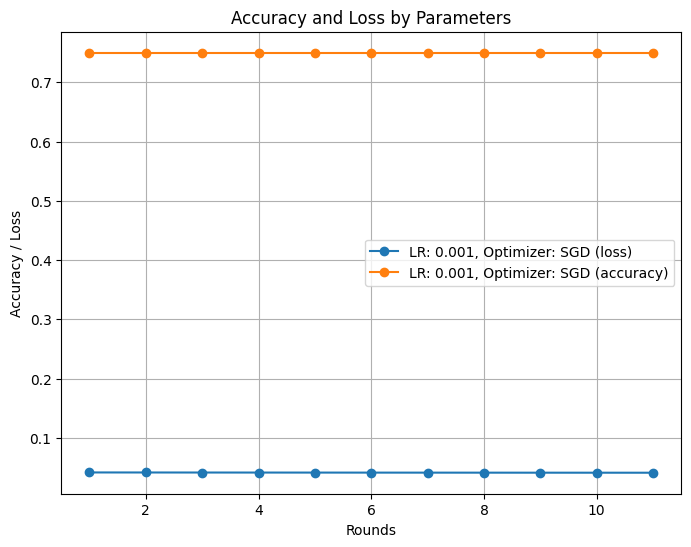

In [17]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [18]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'Midwest',
  'classification_report': "{'confusion matrix': {'TP': 1, 'FP': 0, 'FN': 2, 'TN': 15}, 'Accuracy': 0.889, 'Sensitivity/Recall': 0.333, 'Specificity': 1.0, 'PPV/Precision': 1.0, 'NPV': 0.882, 'F1-score': 0.5, 'False positive rate': 0.0, 'True positive rate': 0.333}"},
 {'node_name': 'South',
  'classification_report': "{'confusion matrix': {'TP': 1, 'FP': 1, 'FN': 4, 'TN': 26}, 'Accuracy': 0.844, 'Sensitivity/Recall': 0.2, 'Specificity': 0.963, 'PPV/Precision': 0.5, 'NPV': 0.867, 'F1-score': 0.286, 'False positive rate': 0.037, 'True positive rate': 0.2}"},
 {'node_name': 'West',
  'classification_report': "{'confusion matrix': {'TP': 9, 'FP': 8, 'FN': 12, 'TN': 64}, 'Accuracy': 0.785, 'Sensitivity/Recall': 0.429, 'Specificity': 0.889, 'PPV/Precision': 0.529, 'NPV': 0.842, 'F1-score': 0.474, 'False positive rate': 0.111, 'True positive rate': 0.429}"},
 {'node_name': 'Northeast',
  'classification_report': "{'confusion matrix': {'TP': 5, 'FP': 5, 'FN': 7, 'TN'